# (함수) DataFrame으로 불러오는 함수

In [ ]:
import pandas as pd

In [2]:
def openDataFrame(path):
    return pd.read_csv(path, on_bad_lines='skip', encoding = "ISO-8859-1")

# 0. 원본 데이터 :  Wine Quality Prediction Analysis - Classification

In [3]:
path_wine = './winequality.csv'

In [4]:
df_wine = openDataFrame(path_wine)
df_wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# 1. 전처리기(나만의 변환기들)

In [5]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

## 1.1 변환기: Type 이진화

In [6]:
class TypeBinaryConverter(BaseEstimator, TransformerMixin):
    def __init__(self, name='type'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = (X[self.name] == 'white').astype(int)
        return X

## 1.2 변환기: quality 3->4, 9->8 변환

In [7]:
class MergeQuality(BaseEstimator, TransformerMixin):
    def __init__(self, name='quality'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = X[self.name].replace({3:4, 9:8})
        return X

## 1.3 변환기: quality 4, ... ,8 이진그룹화 변환

In [8]:
class QualityGroups(BaseEstimator, TransformerMixin):
    def __init__(self, listGroups=['quality_4', 'quality_5', 'quality_6', 'quality_7', 'quality_8']):
        self.listGroups = listGroups
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for i, name in enumerate(self.listGroups):
            X[name] = (X['quality']==i+4).astype(int)
        return X

## 1.4 변환기: 특성들의 극단치 모두 제거

In [9]:
class DropOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, scope=5):
        self.scope = scope
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        myList = []
        for name in X.columns:
            if name not in ['type', 'quality']:
                Q1 = X[[name]].quantile(0.25)
                Q3 = X[[name]].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.scope * IQR
                upper_bound = Q3 + self.scope * IQR

                # 극단치가 있는 열과 행을 찾음
                outlier_cols = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[1]
                outlier_rows = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[0]

                # 극단치가 있는 행의 인덱스를 반환
                outlier_indices = pd.Series(outlier_rows).unique()    
                myList += list(outlier_indices)
        newDf = X.copy().drop(myList, axis=0)
        return newDf

## 1.5 변환기: log_scaler

In [10]:
import numpy as np

class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self, listNames=['chlorides', 'residual sugar']):
        self.listNames = listNames
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for name in self.listNames:
            X[name] = [np.log(x+1) for x in list(X[name])]
        return X

In [11]:
# logScaler = LogScaler()
# logScaler.transform(df_wine.iloc[:, 1:])

## 1.6 KNN이용한 결측치 채우기

In [12]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

## 1.7 DataFrame 포맷으로 되돌리기

In [13]:
class FormatDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, column_names=['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality','quality_4','quality_5','quality_6','quality_7','quality_8']):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.column_names)

In [86]:
class FormatDataFrame_test(BaseEstimator, TransformerMixin):
    def __init__(self, column_names=['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.column_names)

# 2. 전처리 파이프라인 구성

## 2.1 Pipeline을 이용한 전처리 작동 코드

In [14]:
from sklearn.pipeline import Pipeline

preproc_pipeline = Pipeline([
    ('binary_type', TypeBinaryConverter()), # type변수를 0,1 binary화
    ('drop_outliers', DropOutliers(scope=5)), # 이상치 제거
    ('merge_quality', MergeQuality()), # quality변수 3->4, 9->8 변환
    ('quality_groups', QualityGroups()), # quality변수 one-hot encode(binary 모델 구축을 위한)
    ('log_scaler', LogScaler()), # log정규화
    ('knn_imputer', KNNImputer(n_neighbors=2, weights="uniform")), # 결측치 KNN 메꾸기
    ('format_dataframe', FormatDataFrame()) # 데이터프레임으로 재정의
])

# 각단계 전처리를 끄고 싶으면(하지 않고 싶으면), 각 라인을 주석처리하면 됨.
# 예를 들어, 두 번째 줄 ('drop_outliers', DropOutliers(scope=5))을 주석처리하면 극단치 제거가 되지 않음.

In [15]:
# 다음과 같이 일반적인 estimator처럼 fit_transform() 메소드로 전처리 가능
df_preproc = preproc_pipeline.fit_transform(df_wine.copy())

In [87]:
preproc_pipeline_test = Pipeline([
    ('binary_type', TypeBinaryConverter()), # type변수를 0,1 binary화
    ('drop_outliers', DropOutliers(scope=5)), # 이상치 제거
    ('merge_quality', MergeQuality()), # quality변수 3->4, 9->8 변환
    #('quality_groups', QualityGroups()), # quality변수 one-hot encode(binary 모델 구축을 위한)
    ('log_scaler', LogScaler()), # log정규화
    ('knn_imputer', KNNImputer(n_neighbors=2, weights="uniform")), # 결측치 KNN 메꾸기
    ('format_dataframe', FormatDataFrame_test()) # 데이터프레임으로 재정의
])

df_test = preproc_pipeline_test.fit_transform(df_wine.copy())

In [88]:
df_test

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.450,8.8,6.0
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.490,9.5,6.0
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.440,10.1,6.0
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.400,9.9,6.0
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.400,9.9,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.580,10.5,5.0
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.845,11.2,6.0
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.750,11.0,6.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.710,10.2,5.0


# 3. 전처리된 데이터프레임으로 작업하기

In [16]:
# 전처리된 데이터프레임 호출
df_preproc

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_4,quality_5,quality_6,quality_7,quality_8
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8,6.0,0.0,0.0,1.0,0.0,0.0
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5,6.0,0.0,0.0,1.0,0.0,0.0
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1,6.0,0.0,0.0,1.0,0.0,0.0
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,0.0,1.0,0.0,0.0,0.0
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2,6.0,0.0,0.0,1.0,0.0,0.0
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,0.0,0.0,1.0,0.0,0.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# 이렇게 하면 X
X = df_preproc.iloc[:, :-6]
X

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2


In [18]:
# y 클래스별 이진변수 생성
for i in range(4, 9):
    column_name = 'quality_' + str(i)
    globals()['y_'+str(i)] = df_preproc[[column_name]]

# 4. Training-Validation-Test Set 나누기 및 모델 추가 학습

In [183]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

for i in range(4, 9):
    column_name = 'quality_' + str(i)
    globals()['y_'+str(i)] = df_preproc[[column_name]]
    # 데이터셋을 트레이닝 셋과 임시 셋으로 60:40 비율로 나눔
    globals()['X_'+str(i)+'_train'], globals()['X_'+str(i)+'_tmp'], globals()['y_'+str(i)+'_train'], globals()['y_'+str(i)+'_tmp'] = train_test_split(X, globals()['y_'+str(i)], test_size=0.4, random_state=100)
    # oversampling(ros), undersampling(rus)
    ros = SMOTE(k_neighbors=4)
    globals()['X_'+str(i)+'_train_ros'], globals()['y_'+str(i)+'_train_ros'] = ros.fit_resample(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    rus = RandomUnderSampler(random_state=100)
    globals()['X_'+str(i)+'_train_rus'], globals()['y_'+str(i)+'_train_rus'] = rus.fit_resample(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    # 임시 셋을 밸리데이션 셋과 테스트 셋으로 50:50 비율로 나눔
    globals()['X_'+str(i)+'_val'], globals()['X_'+str(i)+'_test'], globals()['y_'+str(i)+'_val'], globals()['y_'+str(i)+'_test'] = train_test_split(globals()['X_'+str(i)+'_tmp'], globals()['y_'+str(i)+'_tmp'], test_size=0.5, random_state=100)

# 데이터셋을 트레이닝 셋과 임시 셋으로 60:40 비율로 나눔
X_train, X_tmp, y_train, y_tmp = train_test_split(df_test.iloc[:, :12], df_test.iloc[:, 12:], test_size=0.4, random_state=100)
ros = SMOTE(k_neighbors=4)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
rus = RandomUnderSampler(random_state=100)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
# 임시 셋을 밸리데이션 셋과 테스트 셋으로 50:50 비율로 나눔
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=100)

X_train_val_ros, y_train_val_ros = ros.fit_resample(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
X_train_val_rus, y_train_val_rus = rus.fit_resample(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
X_train_val, y_train_val = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])


In [58]:
# 모델로드
import joblib

model_log_orign_class4 = joblib.load('./model_files/model_logistic_orign_class_4.joblib')
model_log_over_class5 = joblib.load('./model_files/model_logistic_over_class_5.joblib')
model_log_over_class6 = joblib.load('./model_files/model_logistic_over_class_6.joblib')
model_log_orign_class7 = joblib.load('./model_files/model_logistic_orign_class_7.joblib')
model_log_over_class8 = joblib.load('./model_files/model_logistic_over_class_8.joblib')

model_rnf_over_class4 = joblib.load('./model_files/model_rnf_over_class_4.joblib')
model_rnf_over_class5 = joblib.load('./model_files/model_rnf_over_class_5.joblib')
model_rnf_over_class6 = joblib.load('./model_files/model_rnf_over_class_6.joblib')
model_rnf_over_class7 = joblib.load('./model_files/model_rnf_over_class_7.joblib')
model_rnf_orign_class8 = joblib.load('./model_files/model_rnf_orign_class_8.joblib')

model_svc_over_class4 = joblib.load('./model_files/model_SVC_over_class_4.joblib')
model_svc_over_class5 = joblib.load('./model_files/model_SVC_over_class_5.joblib')
model_svc_under_class6 = joblib.load('./model_files/model_SVC_under_class_6.joblib')
model_svc_over_class7 = joblib.load('./model_files/model_SVC_over_class_7.joblib')
model_svc_over_class8 = joblib.load('./model_files/model_SVC_over_class_8.joblib')

model_xgb_over_class4 = joblib.load('./model_files/model_xgb_over_class_4.joblib')
model_xgb_orign_class5 = joblib.load('./model_files/model_xgb_orign_class_5.joblib')
model_xgb_under_class6 = joblib.load('./model_files/model_xgb_under_class_6.joblib')
model_xgb_over_class7 = joblib.load('./model_files/model_xgb_over_class_7.joblib')
model_xgb_orign_class8 = joblib.load('./model_files/model_xgb_orign_class_8.joblib')

model_gdb_orign_class4 = joblib.load('./model_files/model_gb_orign_class_4.joblib')
model_gdb_over_class5 = joblib.load('./model_files/model_gb_over_class_5.joblib')
model_gdb_over_class6 = joblib.load('./model_files/model_gb_over_class_6.joblib')
model_gdb_over_class7 = joblib.load('./model_files/model_gb_over_class_7.joblib')
model_gdb_orign_class8 = joblib.load('./model_files/model_gb_orign_class_8.joblib')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DummyClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator GradientBoost

In [264]:

model_ext_over_class4 = joblib.load('./model_files/model_ext_over_class_4.joblib')
model_ext_under_class5 = joblib.load('./model_files/model_ext_under_class_5.joblib')
model_ext_over_class6 = joblib.load('./model_files/model_ext_over_class_6.joblib')
model_ext_over_class7 = joblib.load('./model_files/model_ext_over_class_7.joblib')
model_ext_orign_class8 = joblib.load('./model_files/model_ext_orign_class_8.joblib')

In [20]:
## validation data 추가학습을 위한 over/undersampling
for i in range(4, 9):
    # oversampling(ros), undersampling(rus)
    ros = SMOTE(k_neighbors=4)
    globals()['X_'+str(i)+'_val_ros'], globals()['y_'+str(i)+'_val_ros'] = ros.fit_resample(globals()['X_'+str(i)+'_val'], globals()['y_'+str(i)+'_val'])
    rus = RandomUnderSampler(random_state=100)
    globals()['X_'+str(i)+'_val_rus'], globals()['y_'+str(i)+'_val_rus'] = rus.fit_resample(globals()['X_'+str(i)+'_val'], globals()['y_'+str(i)+'_val'])

In [59]:
# 추가학습 진행
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

## logistic
model_log_orign_class4.fit(X_4_val, y_4_val)
model_log_over_class5.fit(X_5_val_ros, y_5_val_ros)
model_log_over_class6.fit(X_6_val_ros, y_6_val_ros)
model_log_orign_class7.fit(X_7_val, y_7_val)
model_log_over_class8.fit(X_8_val_ros, y_8_val_ros)

## Randomforest
model_rnf_over_class4.fit(X_4_val_ros, y_4_val_ros)
model_rnf_over_class5.fit(X_5_val_ros, y_5_val_ros)
model_rnf_over_class6.fit(X_6_val_ros, y_6_val_ros)
model_rnf_over_class7.fit(X_7_val_ros, y_7_val_ros)
model_rnf_orign_class8.fit(X_8_val, y_8_val)

## SVC
model_svc_over_class4.fit(X_4_val_ros, y_4_val_ros)
model_svc_over_class5.fit(X_5_val_ros, y_5_val_ros)
model_svc_under_class6.fit(X_6_val_rus, y_6_val_rus)
model_svc_over_class7.fit(X_7_val_ros, y_7_val_ros)
model_svc_over_class8.fit(X_8_val_ros, y_8_val_ros)

## GradientBoosting
model_gdb_orign_class4.fit(X_4_val, y_4_val)
model_gdb_over_class5.fit(X_5_val_ros, y_5_val_ros)
model_gdb_over_class6.fit(X_5_val_ros, y_5_val_ros)
model_gdb_over_class7.fit(X_5_val_ros, y_5_val_ros)
model_gdb_orign_class8.fit(X_8_val, y_8_val)

## ExtraTreesClassifier
model_ext_over_class4.fit(X_4_val_ros, y_4_val_ros)
model_ext_under_class5.fit(X_5_val_rus, y_5_val_rus)
model_ext_over_class6.fit(X_5_val_ros, y_5_val_ros)
model_ext_over_class7.fit(X_5_val_ros, y_5_val_ros)
model_ext_orign_class8.fit(X_8_val, y_8_val)

## xgboost
model_xgb_over_class4.fit(X_4_val_ros, y_4_val_ros)
model_xgb_orign_class5.fit(X_5_val, y_5_val)
model_xgb_under_class6.fit(X_5_val_rus, y_5_val_rus)
model_xgb_over_class7.fit(X_5_val_ros, y_5_val_ros)
model_xgb_orign_class8.fit(X_8_val, y_8_val)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/lin

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5336699231206312,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# 5. VotingClassifier

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [110]:
def evaluate_model_binary(y_true, y_pred_list, model_names=None):
    # 평가지표 계산
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
    scores = []
    for i, y_pred in enumerate(y_pred_list):
        cm_i = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        scores.append([acc, precision, recall, f1, auc_score])
    
    # 모델 이름 리스트
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(y_pred_list))]

    # 평가지표 출력
    header_format = "{:^15s} | " + " | ".join(["{:^10s}"] * len(metrics))
    row_format = "{:^15s} | " + " | ".join(["{:^10.4f}"] * len(metrics))
    print(header_format.format("", *metrics))
    print('-' * 80)
    for i, score in enumerate(scores):
        print(row_format.format(model_names[i], *score))
    print('-' * 80)

    # ROC curve 출력
    plt.figure(figsize=(5, 5))
    for i, y_pred in enumerate(y_pred_list):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_names[i]} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer

# 평가지표 함수
def evaluate_model(y_true, y_pred_list, model_names=None):
    # 평가지표 계산
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    scores = []
    for i, y_pred in enumerate(y_pred_list):
        cm_i = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        scores.append([acc, precision, recall, f1])
    
    # 모델 이름 리스트
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(y_pred_list))]

    # 평가지표 출력
    header_format = "{:^15s} | " + " | ".join(["{:^10s}"] * len(metrics))
    row_format = "{:^15s} | " + " | ".join(["{:^10.4f}"] * len(metrics))
    print(header_format.format("", *metrics))
    print('-' * 80)
    for i, score in enumerate(scores):
        print(row_format.format(model_names[i], *score))
    print('-' * 80)

In [172]:
def eval_model(y_true, y_pred):
    # Confusion Matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=[4,5,6,7,8])
    print(confusion_mat)
    
    # Total Accuracy
    accuracy = accuracy_score(y_true, y_pred) # 전체 정확도
    print(accuracy)
    
    # Class Accuracy & Macro / Weighted Accuracy
    class_names = [4,5,6,7,8] # 클래스 이름
    macro_accuracy = 0
    weighted_accuracy = 0

    for class_name in class_names:
        indices = [i for i, x in enumerate(y_true) if x == class_name] # 해당 클래스의 샘플 인덱스
        y_true_class = [y_true[i] for i in indices]
        y_pred_class = [y_pred[i] for i in indices]
        accuracy_class = accuracy_score(y_true_class, y_pred_class) # 해당 클래스의 정확도
        precision_class = precision_score(y_true, y_pred, labels=[class_name], average='micro')
        recall_class = recall_score(y_true, y_pred, labels=[class_name], average='micro')
        f1_class = f1_score(y_true, y_pred, labels=[class_name], average='micro')
        print("Class", class_name)
        print(class_name, "class Accuracy: ", accuracy_class)
        print(class_name, "class Precision: ", precision_class)
        print(class_name, "class Recall: ", recall_class)
        print(class_name, "class f1: ", f1_class)
        macro_accuracy += accuracy_class
        weighted_accuracy += accuracy_class * len(indices)

    macro_accuracy /= len(class_names) # 매크로 평균
    weighted_accuracy /= len(y_true) # 가중 평균
    print("Macro-Average Accuracy:", macro_accuracy)
    print("Weighted-Average Accuracy:", weighted_accuracy)

In [198]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def eval_model_v2(y_true, y_pred):
    class_names = [4, 5, 6, 7, 8]

    # Confusion Matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=class_names)
    print("Confusion Matrix:\n", confusion_mat)

    # Total Accuracy
    total_accuracy = accuracy_score(y_true, y_pred)
    print("Total Accuracy:", total_accuracy)

    # Class-wise Metrics
    precision = precision_score(y_true, y_pred, labels=class_names, average=None)
    recall = recall_score(y_true, y_pred, labels=class_names, average=None)
    f1 = f1_score(y_true, y_pred, labels=class_names, average=None)

    for i, class_name in enumerate(class_names):
        print(f"Class {class_name}:")
        print(f"  Accuracy: {confusion_mat[i, i] / sum(confusion_mat[i, :])}")
        print(f"  Precision: {precision[i]}")
        print(f"  Recall: {recall[i]}")
        print(f"  F1-score: {f1[i]}")

    # Macro-Average Metrics
    macro_precision = sum(precision) / len(class_names)
    macro_recall = sum(recall) / len(class_names)
    macro_f1 = sum(f1) / len(class_names)
    print("\nMacro-Average Metrics:")
    print(f"  Macro-Average Precision: {macro_precision}")
    print(f"  Macro-Average Recall: {macro_recall}")
    print(f"  Macro-Average F1-score: {macro_f1}")

    # Weighted-Average Metrics
    weights = [sum(confusion_mat[i, :]) for i in range(len(class_names))]
    total_samples = sum(weights)
    weighted_precision = sum(precision[i] * weights[i] for i in range(len(class_names))) / total_samples
    weighted_recall = sum(recall[i] * weights[i] for i in range(len(class_names))) / total_samples
    weighted_f1 = sum(f1[i] * weights[i] for i in range(len(class_names))) / total_samples
    print("\nWeighted-Average Metrics:")
    print(f"  Weighted-Average Precision: {weighted_precision}")
    print(f"  Weighted-Average Recall: {weighted_recall}")
    print(f"  Weighted-Average F1-score: {weighted_f1}")

In [62]:
# feature importance 출력 함수
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def feature_importance(X, y, lr_models, model_names):
    fig, ax = plt.subplots(1, len(lr_models), figsize=(35, 5)) # 여러 모델의 그래프를 가로로 나열하기 위해 subplot 사용
    for i, lr_model in enumerate(lr_models):
        # feature importance 계산
        importance = lr_model.coef_[0]
        # 절대값 취해서 정규화
        importance = np.abs(importance) / np.sum(np.abs(importance))

        # feature importance 그래프 출력
        sorted_idx = np.argsort(importance)# 내림차순으로 정렬된 index 반환
        ax[i].barh(range(len(X.columns)), importance[sorted_idx])
        ax[i].set_yticks(range(len(X.columns)))
        ax[i].set_yticklabels(X.columns[sorted_idx])
        ax[i].set_title(f'Feature Importance of {model_names[i]}')

        # feature importance 목록 출력
        importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})
        importance_df = importance_df.sort_values('importance', ascending=False)
        print(f'{model_names[i]} Feature Importance')
        print(importance_df)
    
    plt.show()

                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
      log       |   0.7773   |   0.0976   |   0.6170   |   0.1686   |   0.7002  
      rnf       |   0.9439   |   0.1951   |   0.1702   |   0.1818   |   0.5718  
      svc       |   0.9626   |   0.0000   |   0.0000   |   0.0000   |   0.4996  
      xgb       |   0.9431   |   0.2292   |   0.2340   |   0.2316   |   0.6021  
      gdb       |   0.9587   |   0.1250   |   0.0213   |   0.0364   |   0.5078  
      ext       |   0.9525   |   0.2083   |   0.1064   |   0.1408   |   0.5455  
--------------------------------------------------------------------------------


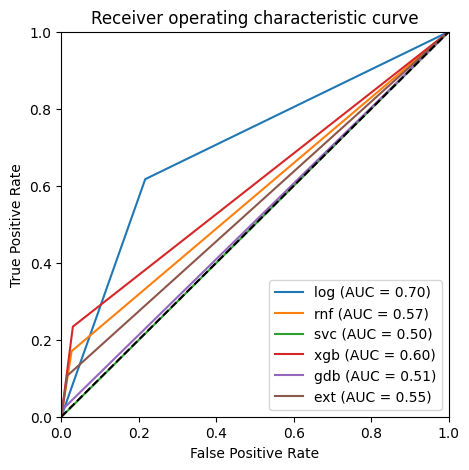

                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
      log       |   0.7173   |   0.5656   |   0.7300   |   0.6374   |   0.7204  
      rnf       |   0.7625   |   0.6416   |   0.6842   |   0.6622   |   0.7435  
      svc       |   0.6885   |   0.6350   |   0.1991   |   0.3031   |   0.5700  
      xgb       |   0.7632   |   0.6873   |   0.5584   |   0.6162   |   0.7137  
      gdb       |   0.7461   |   0.6247   |   0.6362   |   0.6304   |   0.7195  
      ext       |   0.7375   |   0.5825   |   0.8078   |   0.6769   |   0.7545  
--------------------------------------------------------------------------------


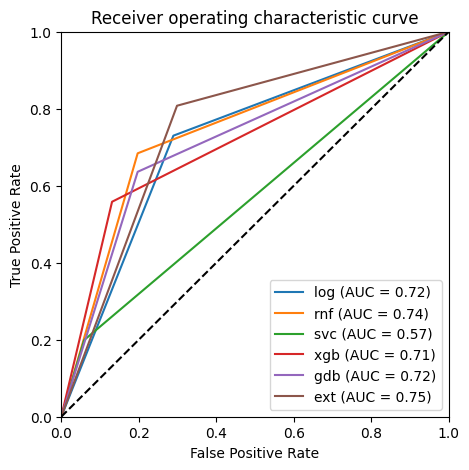

                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
      log       |   0.5483   |   0.4721   |   0.6278   |   0.5390   |   0.5592  
      rnf       |   0.6347   |   0.5628   |   0.5889   |   0.5756   |   0.6284  
      svc       |   0.5709   |   0.4861   |   0.3574   |   0.4120   |   0.5416  
      xgb       |   0.4128   |   0.3193   |   0.3500   |   0.3339   |   0.4042  
      gdb       |   0.4221   |   0.2694   |   0.2185   |   0.2413   |   0.3942  
      ext       |   0.4151   |   0.2741   |   0.2370   |   0.2542   |   0.3907  
--------------------------------------------------------------------------------


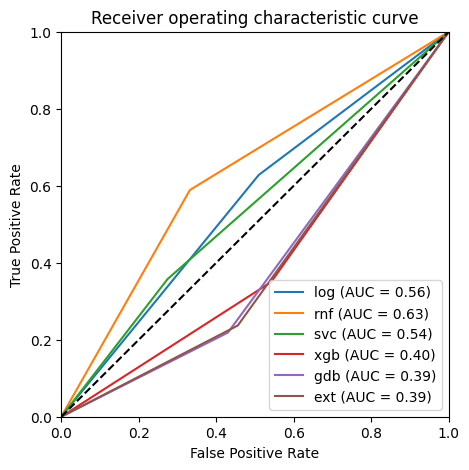

                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
      log       |   0.7181   |   0.3460   |   0.7593   |   0.4754   |   0.7345  
      rnf       |   0.8084   |   0.4395   |   0.5046   |   0.4698   |   0.6872  
      svc       |   0.8193   |   0.4420   |   0.2824   |   0.3446   |   0.6052  
      xgb       |   0.4992   |   0.0266   |   0.0556   |   0.0360   |   0.3223  
      gdb       |   0.5016   |   0.0268   |   0.0556   |   0.0361   |   0.3237  
      ext       |   0.5117   |   0.0187   |   0.0370   |   0.0249   |   0.3224  
--------------------------------------------------------------------------------


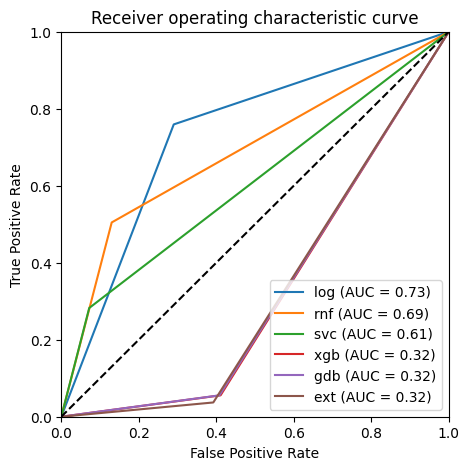

                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
      log       |   0.7196   |   0.0842   |   0.7273   |   0.1509   |   0.7233  
      rnf       |   0.9688   |   1.0000   |   0.0909   |   0.1667   |   0.5455  
      svc       |   0.9455   |   0.1579   |   0.1364   |   0.1463   |   0.5553  
      xgb       |   0.9634   |   0.3846   |   0.1136   |   0.1754   |   0.5536  
      gdb       |   0.9634   |   0.3636   |   0.0909   |   0.1455   |   0.5426  
      ext       |   0.9688   |   1.0000   |   0.0909   |   0.1667   |   0.5455  
--------------------------------------------------------------------------------


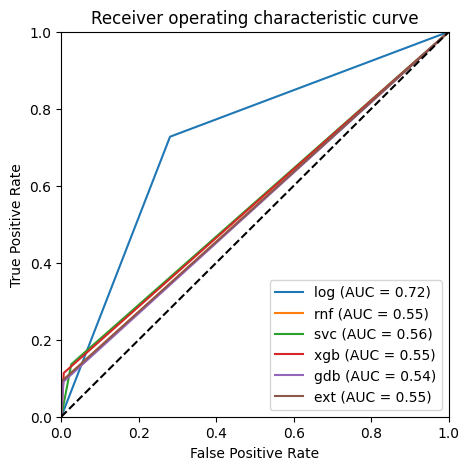

In [267]:
# 이진 분류기 f1 계산
prediction_class_4_1 = model_log_orign_class4.predict(X_test)
prediction_class_4_2 = model_rnf_over_class4.predict(X_test)
prediction_class_4_3 = model_svc_over_class4.predict(X_test)
prediction_class_4_4 = model_xgb_over_class4.predict(X_test)
prediction_class_4_5 = model_gdb_orign_class4.predict(X_test)
prediction_class_4_6 = model_ext_over_class4.predict(X_test)

prediction_class_5_1 = model_log_over_class5.predict(X_test)
prediction_class_5_2 = model_rnf_over_class5.predict(X_test)
prediction_class_5_3 = model_svc_over_class5.predict(X_test)
prediction_class_5_4 = model_xgb_orign_class5.predict(X_test)
prediction_class_5_5 = model_gdb_over_class5.predict(X_test)
prediction_class_5_6 = model_ext_under_class5.predict(X_test)

prediction_class_6_1 = model_log_over_class6.predict(X_test)
prediction_class_6_2 = model_rnf_over_class6.predict(X_test)
prediction_class_6_3 = model_svc_under_class6.predict(X_test)
prediction_class_6_4 = model_xgb_under_class6.predict(X_test)
prediction_class_6_5 = model_gdb_over_class6.predict(X_test)
prediction_class_6_6 = model_ext_over_class6.predict(X_test)

prediction_class_7_1 = model_log_orign_class7.predict(X_test)
prediction_class_7_2 = model_rnf_over_class7.predict(X_test)
prediction_class_7_3 = model_svc_over_class7.predict(X_test)
prediction_class_7_4 = model_xgb_over_class7.predict(X_test)
prediction_class_7_5 = model_gdb_over_class7.predict(X_test)
prediction_class_7_6 = model_ext_over_class7.predict(X_test)

prediction_class_8_1 = model_log_over_class8.predict(X_test)
prediction_class_8_2 = model_rnf_orign_class8.predict(X_test)
prediction_class_8_3 = model_svc_over_class8.predict(X_test)
prediction_class_8_4 = model_xgb_orign_class8.predict(X_test)
prediction_class_8_5 = model_gdb_orign_class8.predict(X_test)
prediction_class_8_6 = model_ext_orign_class8.predict(X_test)

evaluate_model_binary(y_4_test, [prediction_class_4_1, prediction_class_4_2, prediction_class_4_3, prediction_class_4_4, prediction_class_4_5, prediction_class_4_6], ['log', 'rnf', 'svc', 'xgb', 'gdb', 'ext'])
evaluate_model_binary(y_5_test, [prediction_class_5_1, prediction_class_5_2, prediction_class_5_3, prediction_class_5_4, prediction_class_5_5, prediction_class_5_6], ['log', 'rnf', 'svc', 'xgb', 'gdb', 'ext'])
evaluate_model_binary(y_6_test, [prediction_class_6_1, prediction_class_6_2, prediction_class_6_3, prediction_class_6_4, prediction_class_6_5, prediction_class_6_6], ['log', 'rnf', 'svc', 'xgb', 'gdb', 'ext'])
evaluate_model_binary(y_7_test, [prediction_class_7_1, prediction_class_7_2, prediction_class_7_3, prediction_class_7_4, prediction_class_7_5, prediction_class_7_6], ['log', 'rnf', 'svc', 'xgb', 'gdb', 'ext'])
evaluate_model_binary(y_8_test, [prediction_class_8_1, prediction_class_8_2, prediction_class_8_3, prediction_class_8_4, prediction_class_8_5, prediction_class_8_6], ['log', 'rnf', 'svc', 'xgb', 'gdb', 'ext'])

In [268]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder


#                 |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
# --------------------------------------------------------------------------------
#       log       |   0.7773   |   0.0976   |   0.6170   |   0.1686   |   0.7002  
#       rnf       |   0.9439   |   0.1951   |   0.1702   |   0.1818   |   0.5718  
#       svc       |   0.9626   |   0.0000   |   0.0000   |   0.0000   |   0.4996  
#       xgb       |   0.9431   |   0.2292   |   0.2340   |   0.2316   |   0.6021  
#       gdb       |   0.9587   |   0.1250   |   0.0213   |   0.0364   |   0.5078  
#       ext       |   0.9525   |   0.2083   |   0.1064   |   0.1408   |   0.5455  
# --------------------------------------------------------------------------------
#                 |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
# --------------------------------------------------------------------------------
#       log       |   0.7173   |   0.5656   |   0.7300   |   0.6374   |   0.7204  
#       rnf       |   0.7625   |   0.6416   |   0.6842   |   0.6622   |   0.7435  
#       svc       |   0.6885   |   0.6350   |   0.1991   |   0.3031   |   0.5700  
#       xgb       |   0.7632   |   0.6873   |   0.5584   |   0.6162   |   0.7137  
#       gdb       |   0.7461   |   0.6247   |   0.6362   |   0.6304   |   0.7195  
#       ext       |   0.7375   |   0.5825   |   0.8078   |   0.6769   |   0.7545  
# --------------------------------------------------------------------------------
#                 |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
# --------------------------------------------------------------------------------
#       log       |   0.5483   |   0.4721   |   0.6278   |   0.5390   |   0.5592  
#       rnf       |   0.6347   |   0.5628   |   0.5889   |   0.5756   |   0.6284  
#       svc       |   0.5709   |   0.4861   |   0.3574   |   0.4120   |   0.5416  
#       xgb       |   0.4128   |   0.3193   |   0.3500   |   0.3339   |   0.4042  
#       gdb       |   0.4221   |   0.2694   |   0.2185   |   0.2413   |   0.3942  
#       ext       |   0.4151   |   0.2741   |   0.2370   |   0.2542   |   0.3907  
# --------------------------------------------------------------------------------
#                 |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
# --------------------------------------------------------------------------------
#       log       |   0.7181   |   0.3460   |   0.7593   |   0.4754   |   0.7345  
#       rnf       |   0.8084   |   0.4395   |   0.5046   |   0.4698   |   0.6872  
#       svc       |   0.8193   |   0.4420   |   0.2824   |   0.3446   |   0.6052  
#       xgb       |   0.4992   |   0.0266   |   0.0556   |   0.0360   |   0.3223  
#       gdb       |   0.5016   |   0.0268   |   0.0556   |   0.0361   |   0.3237  
#       ext       |   0.5117   |   0.0187   |   0.0370   |   0.0249   |   0.3224  
# --------------------------------------------------------------------------------
#                 |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
# --------------------------------------------------------------------------------
#       log       |   0.7196   |   0.0842   |   0.7273   |   0.1509   |   0.7233  
#       rnf       |   0.9688   |   1.0000   |   0.0909   |   0.1667   |   0.5455  
#       svc       |   0.9455   |   0.1579   |   0.1364   |   0.1463   |   0.5553  
#       xgb       |   0.9634   |   0.3846   |   0.1136   |   0.1754   |   0.5536  
#       gdb       |   0.9634   |   0.3636   |   0.0909   |   0.1455   |   0.5426  
#       ext       |   0.9688   |   1.0000   |   0.0909   |   0.1667   |   0.5455  
# --------------------------------------------------------------------------------

## 가중치 계산
class4_f1 = [0.1686, 0.1818, 0.0000, 0.2316, 0.0364, 0.1408]
class5_f1 = [0.6374, 0.6622, 0.3031, 0.6162, 0.6304, 0.6769]
class6_f1 = [0.5390, 0.5756, 0.4120, 0.3339, 0.2413, 0.2542]
class7_f1 = [0.4754, 0.4698, 0.3446, 0.0360, 0.0361, 0.0249]
class8_f1 = [0.1509, 0.1667, 0.1463, 0.1754, 0.1455, 0.1667]

class4_precision = [0.0976, 0.1951, 0.0, 0.2292, 0.1250, 0.2083]
class5_precision = [0.5656, 0.6416, 0.6350, 0.6873, 0.6247, 0.5825]
class6_precision = [0.4721, 0.5628, 0.4861, 0.3193, 0.2694, 0.2741]
class7_precision = [0.3460, 0.4395, 0.4420, 0.0266, 0.0268, 0.0187]
class8_precision = [0.0842, 1.0000, 0.1579, 0.3846, 0.3636, 1.0]

class4_f1_sum = sum(class4_f1)
class5_f1_sum = sum(class5_f1)
class6_f1_sum = sum(class6_f1)
class7_f1_sum = sum(class7_f1)
class8_f1_sum = sum(class8_f1)

class4_f1_norm = [round(i/class4_f1_sum, 2) for i in class4_f1]
class5_f1_norm = [round(i/class5_f1_sum, 2) for i in class5_f1]
class6_f1_norm = [round(i/class6_f1_sum, 2) for i in class6_f1]
class7_f1_norm = [round(i/class7_f1_sum, 2) for i in class7_f1]
class8_f1_norm = [round(i/class8_f1_sum, 2) for i in class8_f1]

print(class4_f1_norm)
print(class5_f1_norm)
print(class6_f1_norm)
print(class7_f1_norm)
print(class8_f1_norm)

class4_precision_sum = sum(class4_precision)
class5_precision_sum = sum(class5_precision)
class6_precision_sum = sum(class6_precision)
class7_precision_sum = sum(class7_precision)
class8_precision_sum = sum(class8_precision)

class4_precision_norm = [round(i/class4_precision_sum, 2) for i in class4_f1]
class5_precision_norm = [round(i/class5_precision_sum, 2) for i in class5_f1]
class6_precision_norm = [round(i/class6_precision_sum, 2) for i in class6_f1]
class7_precision_norm = [round(i/class7_precision_sum, 2) for i in class7_f1]
class8_precision_norm = [round(i/class8_precision_sum, 2) for i in class8_f1]

print(class4_precision_norm)
print(class5_precision_norm)
print(class6_precision_norm)
print(class7_precision_norm)
print(class8_precision_norm)


[0.22, 0.24, 0.0, 0.31, 0.05, 0.19]
[0.18, 0.19, 0.09, 0.17, 0.18, 0.19]
[0.23, 0.24, 0.17, 0.14, 0.1, 0.11]
[0.34, 0.34, 0.25, 0.03, 0.03, 0.02]
[0.16, 0.18, 0.15, 0.18, 0.15, 0.18]
[0.2, 0.21, 0.0, 0.27, 0.04, 0.16]
[0.17, 0.18, 0.08, 0.16, 0.17, 0.18]
[0.23, 0.24, 0.17, 0.14, 0.1, 0.11]
[0.37, 0.36, 0.27, 0.03, 0.03, 0.02]
[0.05, 0.06, 0.05, 0.06, 0.05, 0.06]


In [271]:
# 각 클래스에 대한 가중치 리스트
class_weights_uni = [
    [0.16, 0.16, 0.16, 0.16, 0.16, 0.16],  # 클래스 4
    [0.16, 0.16, 0.16, 0.16, 0.16, 0.16],  # 클래스 5
    [0.16, 0.16, 0.16, 0.16, 0.16, 0.16],  # 클래스 6
    [0.16, 0.16, 0.16, 0.16, 0.16, 0.16],  # 클래스 7
    [0.16, 0.16, 0.16, 0.16, 0.16, 0.16]  # 클래스 8
]

class_weights_f1 = [
    [0.22, 0.24, 0.0, 0.31, 0.05, 0.19],
    [0.18, 0.19, 0.09, 0.17, 0.18, 0.19],
    [0.23, 0.24, 0.17, 0.14, 0.1, 0.11],
    [0.34, 0.34, 0.25, 0.03, 0.03, 0.02],
    [0.16, 0.18, 0.15, 0.18, 0.15, 0.18]
]

class_weights_precision = [
    [0.2, 0.21, 0.0, 0.27, 0.04, 0.16],
    [0.17, 0.18, 0.08, 0.16, 0.17, 0.18],
    [0.23, 0.24, 0.17, 0.14, 0.1, 0.11],
    [0.37, 0.36, 0.27, 0.03, 0.03, 0.02],
    [0.05, 0.06, 0.05, 0.06, 0.05, 0.06]
]

class_weights_allornothing = [
    [0, 0, 0, 1, 0, 0],
    [0, 0.5, 0, 0, 0, 0.5],
    [0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0],
    [0, 0.4, 0, 0.3, 0, 0.3]
] # f1값을 기준으로 수행

# 각 클래스별로 5개의 모델을 만듦
models = [
    [
model_log_orign_class4,
model_rnf_over_class4,
model_svc_over_class4,
model_xgb_over_class4,
model_gdb_orign_class4,
model_ext_over_class4
    ],
    [
model_log_over_class5,
model_rnf_over_class5,
model_svc_over_class5,
model_xgb_orign_class5,
model_gdb_over_class5,
model_ext_under_class5
    ],
    [
model_log_over_class6,
model_rnf_over_class6,
model_svc_under_class6,
model_xgb_under_class6,
model_gdb_over_class6,
model_ext_over_class6
    ],
    [
model_log_orign_class7,
model_rnf_over_class7,
model_svc_over_class7,
model_xgb_over_class7,
model_gdb_over_class7,
model_ext_over_class7
    ],
    [
model_log_over_class8,
model_rnf_orign_class8,
model_svc_over_class8,
model_xgb_orign_class8,
model_gdb_orign_class8,
model_ext_orign_class8
    ],
]

# 예측 확률을 계산하는 함수
def weighted_prediction(models, weights, X):
    n_classes = len(models)
    weighted_preds = np.zeros((X.shape[0], n_classes))
    
    for i, model_list in enumerate(models):
        for j, model in enumerate(model_list):
            preds = model.predict(X)
            one_hot_preds = OneHotEncoder(sparse=False).fit_transform(preds.reshape(-1, 1))
            weighted_preds[:, i] += one_hot_preds[:, 1] * weights[i][j]
            
    return (weighted_preds.argmax(axis=1) + 4)

# 예측 수행
ensemble_pred_uni = weighted_prediction(models, class_weights_uni, X_test)
ensemble_pred_f1 = weighted_prediction(models, class_weights_f1, X_test)
ensemble_pred_precision = weighted_prediction(models, class_weights_precision, X_test)
ensemble_pred_allornothing = weighted_prediction(models, class_weights_allornothing, X_test)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site

In [272]:
# 평가지표
evaluate_model(y_test, [ensemble_pred_uni, ensemble_pred_f1, ensemble_pred_precision, ensemble_pred_allornothing], ['uniform', 'f1', 'precision', 'allornothing'])

                |  Accuracy  | Precision  |   Recall   |  F1-score 
--------------------------------------------------------------------------------
    uniform     |   0.5522   |   0.5412   |   0.5522   |   0.5426  
      f1        |   0.5428   |   0.5473   |   0.5428   |   0.5361  
   precision    |   0.5405   |   0.5442   |   0.5405   |   0.5297  
 allornothing   |   0.5506   |   0.5763   |   0.5506   |   0.5478  
--------------------------------------------------------------------------------


# 6. StackingClassifier

In [258]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
# 모델 정의
estimators = [
    ('log', LogisticRegression(solver='newton-cg', C =10, max_iter=100, class_weight='balanced', penalty='l2')),
    ('rnf', RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, random_state=100)),
    ('svm', SVC(C=10, gamma=10, kernel='rbf')),
    ('xgb', XGBClassifier(subsample=0.7, reg_lambda=0.0093260334688322, reg_alpha=0.001, n_estimators=200, max_depth=9, learning_rate=0.021544346900318846, gamma=0.4, colsample_bytree=0.6)),
    ('gdb', GradientBoostingClassifier(learning_rate=0.1, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8)),
    ('ext', ExtraTreesClassifier(max_fdepth = None, min_samples_leaf = 1, min_samples_split = 4, n_estimators = 100))
]
clf_log_orign = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf_log_ros = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf_log_rus = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf_rnf_orign = StackingClassifier(
    estimators=estimators, final_estimator=RandomForestClassifier()
)
clf_rnf_ros = StackingClassifier(
    estimators=estimators, final_estimator=RandomForestClassifier()
)
clf_rnf_rus = StackingClassifier(
    estimators=estimators, final_estimator=RandomForestClassifier()
)
clf_svm_orign = StackingClassifier(
    estimators=estimators, final_estimator=SVC()
)
clf_svm_ros = StackingClassifier(
    estimators=estimators, final_estimator=SVC()
)
clf_svm_rus = StackingClassifier(
    estimators=estimators, final_estimator=SVC()
)
clf_xgb_orign = StackingClassifier(
    estimators=estimators, final_estimator=XGBClassifier()
)
clf_xgb_ros = StackingClassifier(
    estimators=estimators, final_estimator=XGBClassifier()
)
clf_xgb_rus = StackingClassifier(
    estimators=estimators, final_estimator=XGBClassifier()
)
clf_gdb_orign = StackingClassifier(
    estimators=estimators, final_estimator=GradientBoostingClassifier()
)
clf_gdb_ros = StackingClassifier(
    estimators=estimators, final_estimator=GradientBoostingClassifier()
)
clf_gdb_rus = StackingClassifier(
    estimators=estimators, final_estimator=GradientBoostingClassifier()
)
clf_ext_orign = StackingClassifier(
    estimators=estimators, final_estimator=ExtraTreesClassifier()
)
clf_ext_ros = StackingClassifier(
    estimators=estimators, final_estimator=ExtraTreesClassifier()
)
clf_ext_rus = StackingClassifier(
    estimators=estimators, final_estimator=ExtraTreesClassifier()
)

# 모델 학습
clf_log_orign_model = clf_log_orign.fit(X_train_val, y_train_val)
clf_log_ros_model = clf_log_ros.fit(X_train_val_ros, y_train_val_ros)
clf_log_rus_model = clf_log_rus.fit(X_train_val_rus, y_train_val_rus)

clf_rnf_orign_model = clf_rnf_orign.fit(X_train_val, y_train_val)
clf_rnf_ros_model = clf_rnf_ros.fit(X_train_val_ros, y_train_val_ros)
clf_rnf_rus_model = clf_rnf_rus.fit(X_train_val_rus, y_train_val_rus)

clf_svm_orign_model = clf_svm_orign.fit(X_train_val, y_train_val)
clf_svm_ros_model = clf_svm_ros.fit(X_train_val_ros, y_train_val_ros)
clf_svm_rus_model = clf_svm_rus.fit(X_train_val_rus, y_train_val_rus)

clf_xgb_orign_model = clf_xgb_orign.fit(X_train_val, y_train_val)
clf_xgb_ros_model = clf_xgb_ros.fit(X_train_val_ros, y_train_val_ros)
clf_xgb_rus_model = clf_xgb_rus.fit(X_train_val_rus, y_train_val_rus)

clf_gdb_orign_model = clf_gdb_orign.fit(X_train_val, y_train_val)
clf_gdb_ros_model = clf_gdb_ros.fit(X_train_val_ros, y_train_val_ros)
clf_gdb_rus_model = clf_gdb_rus.fit(X_train_val_rus, y_train_val_rus)

clf_ext_orign_model = clf_ext_orign.fit(X_train_val, y_train_val)
clf_ext_ros_model = clf_ext_ros.fit(X_train_val_ros, y_train_val_ros)
clf_ext_rus_model = clf_ext_rus.fit(X_train_val_rus, y_train_val_rus)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
P

In [259]:
# 평가지표 : 모델간 요약
evaluate_model(y_test, [
clf_log_orign_model.predict(X_test),
clf_log_ros_model.predict(X_test),
clf_log_rus_model.predict(X_test),
clf_rnf_orign_model.predict(X_test),
clf_rnf_ros_model.predict(X_test),
clf_rnf_rus_model.predict(X_test),
clf_svm_orign_model.predict(X_test),
clf_svm_ros_model.predict(X_test),
clf_svm_rus_model.predict(X_test),
clf_xgb_orign_model.predict(X_test),
clf_xgb_ros_model.predict(X_test),
clf_xgb_rus_model.predict(X_test),
clf_gdb_orign_model.predict(X_test),
clf_gdb_ros_model.predict(X_test),
clf_gdb_rus_model.predict(X_test),
clf_ext_orign_model.predict(X_test),
clf_ext_ros_model.predict(X_test),
clf_ext_rus_model.predict(X_test)
], ['log_orign', 'log_ros', 'log_rus', 'rnf_orign', 'rnf_ros', 'rnf_rus', 'svm_orign', 'svm_ros', 'svm_rus', 'xgb_orign', 'xgb_ros', 'xgb_rus', 'gdb_orign', 'gdb_ros', 'gdb_rus', 'ext_orign', 'ext_ros', 'ext_rus'])

                |  Accuracy  | Precision  |   Recall   |  F1-score 
--------------------------------------------------------------------------------
   log_orign    |   0.6838   |   0.6936   |   0.6838   |   0.6725  
    log_ros     |   0.6745   |   0.6761   |   0.6745   |   0.6678  
    log_rus     |   0.4455   |   0.5281   |   0.4455   |   0.4538  
   rnf_orign    |   0.6776   |   0.6880   |   0.6776   |   0.6675  
    rnf_ros     |   0.6628   |   0.6728   |   0.6628   |   0.6487  
    rnf_rus     |   0.4587   |   0.5490   |   0.4587   |   0.4755  
   svm_orign    |   0.6854   |   0.7239   |   0.6854   |   0.6678  
    svm_ros     |   0.6783   |   0.6783   |   0.6783   |   0.6742  
    svm_rus     |   0.4587   |   0.5283   |   0.4587   |   0.4635  
   xgb_orign    |   0.6745   |   0.6897   |   0.6745   |   0.6657  
    xgb_ros     |   0.6550   |   0.6899   |   0.6550   |   0.6362  
    xgb_rus     |   0.3894   |   0.5179   |   0.3894   |   0.4098  
   gdb_orign    |   0.6838   |   0.

In [260]:
# 평가지표 : 모델별 상세 내용
print('--------------------log_orign--------------------')
eval_model_v2(y_test, clf_log_orign_model.predict(X_test))
print('--------------------log_over--------------------')
eval_model_v2(y_test, clf_log_ros_model.predict(X_test))
print('--------------------log_under--------------------')
eval_model_v2(y_test, clf_log_rus_model.predict(X_test))
print('--------------------rnf_orign--------------------')
eval_model_v2(y_test, clf_rnf_orign_model.predict(X_test))
print('--------------------rnf_over--------------------')
eval_model_v2(y_test, clf_rnf_ros_model.predict(X_test))
print('--------------------rnf_under--------------------')
eval_model_v2(y_test, clf_rnf_rus_model.predict(X_test))
print('--------------------svm_orign--------------------')
eval_model_v2(y_test, clf_svm_orign_model.predict(X_test))
print('--------------------svm_over--------------------')
eval_model_v2(y_test, clf_svm_ros_model.predict(X_test))
print('--------------------svm_under--------------------')
eval_model_v2(y_test, clf_svm_rus_model.predict(X_test))
print('--------------------xgb_orign--------------------')
eval_model_v2(y_test, clf_xgb_orign_model.predict(X_test))
print('--------------------xgb_over--------------------')
eval_model_v2(y_test, clf_xgb_ros_model.predict(X_test))
print('--------------------xgb_under--------------------')
eval_model_v2(y_test, clf_xgb_rus_model.predict(X_test))
print('--------------------gdb_orign--------------------')
eval_model_v2(y_test, clf_gdb_orign_model.predict(X_test))
print('--------------------gdb_over--------------------')
eval_model_v2(y_test, clf_gdb_ros_model.predict(X_test))
print('--------------------gdb_under--------------------')
eval_model_v2(y_test, clf_gdb_rus_model.predict(X_test))
print('--------------------ext_orign--------------------')
eval_model_v2(y_test, clf_gdb_orign_model.predict(X_test))
print('--------------------ext_over--------------------')
eval_model_v2(y_test, clf_gdb_ros_model.predict(X_test))
print('--------------------ext_under--------------------')
eval_model_v2(y_test, clf_gdb_rus_model.predict(X_test))

--------------------log_orign--------------------
Confusion Matrix:
 [[  7  28  11   1   0]
 [  2 316 116   3   0]
 [  4  76 430  30   0]
 [  0   3 102 111   0]
 [  0   0  16  14  14]]
Total Accuracy: 0.6838006230529595
Class 4:
  Accuracy: 0.14893617021276595
  Precision: 0.5384615384615384
  Recall: 0.14893617021276595
  F1-score: 0.23333333333333334
Class 5:
  Accuracy: 0.7231121281464531
  Precision: 0.7470449172576832
  Recall: 0.7231121281464531
  F1-score: 0.7348837209302325
Class 6:
  Accuracy: 0.7962962962962963
  Precision: 0.6370370370370371
  Recall: 0.7962962962962963
  F1-score: 0.7078189300411523
Class 7:
  Accuracy: 0.5138888888888888
  Precision: 0.6981132075471698
  Recall: 0.5138888888888888
  F1-score: 0.592
Class 8:
  Accuracy: 0.3181818181818182
  Precision: 1.0
  Recall: 0.3181818181818182
  F1-score: 0.4827586206896552

Macro-Average Metrics:
  Macro-Average Precision: 0.7241313400606857
  Macro-Average Recall: 0.5000830603452445
  Macro-Average F1-score: 0.5501

In [254]:
# 오차허용한 와인등급예측의 평가지표
def evaluate_wine_grade(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_adj = np.maximum(y_true.reshape(-1) - 1, y_pred)
    y_pred_adj = np.minimum(y_pred, y_true.reshape(-1))
    y_true_penalty = (y_true_adj != y_true.reshape(-1))
    y_pred_penalty = (y_pred_adj != y_pred)
    penalty = np.logical_and(y_true_penalty, y_pred_penalty)
    penalty_weight = np.ones_like(y_true.reshape(-1))
    penalty_weight[penalty] = 2
    acc = accuracy_score(y_true_adj, y_pred_adj, sample_weight=penalty_weight)
    precision = precision_score(y_true_adj, y_pred_adj, average='weighted')
    recall = recall_score(y_true_adj, y_pred_adj, average='weighted')
    f1 = f1_score(y_true_adj, y_pred_adj, average='weighted')
    print(f"  Accuracy: {acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")

In [262]:
models = [
    ('log_orign', clf_log_orign_model),
    ('log_over', clf_log_ros_model),
    ('log_under', clf_log_rus_model),
    ('rnf_orign', clf_rnf_orign_model),
    ('rnf_ros', clf_rnf_ros_model),
    ('rnf_rus', clf_rnf_rus_model),
    ('svm_orign', clf_svm_orign_model),
    ('svm_ros', clf_svm_ros_model),
    ('svm_rus', clf_svm_rus_model),
    ('xgb_orign', clf_xgb_orign_model),
    ('xgb_ros', clf_xgb_ros_model),
    ('xgb_rus', clf_xgb_rus_model),
    ('gdb_orign', clf_gdb_orign_model),
    ('gdb_ros', clf_gdb_ros_model),
    ('gdb_rus', clf_gdb_rus_model),
    ('ext_orign', clf_ext_orign_model),
    ('ext_ros', clf_ext_ros_model),
    ('ext_rus', clf_ext_rus_model),
]

for model_name, model in models:
    print(f'---------------------{model_name}---------------------')
    evaluate_under(y_test, model.predict(X_test))

---------------------log_orign---------------------
  Accuracy: 0.9883177570093458
  Precision: 0.9884946764592637
  Recall: 0.9883177570093458
  F1-score: 0.9876891147638669
---------------------log_over---------------------
  Accuracy: 0.9898753894080997
  Precision: 0.9900390178150895
  Recall: 0.9898753894080997
  F1-score: 0.9893533376682072
---------------------log_under---------------------
  Accuracy: 0.9096573208722741
  Precision: 0.925260366200742
  Recall: 0.9096573208722741
  F1-score: 0.9123468660290062
---------------------rnf_orign---------------------
  Accuracy: 0.9883177570093458
  Precision: 0.9884946764592637
  Recall: 0.9883177570093458
  F1-score: 0.9876891147638669
---------------------rnf_ros---------------------
  Accuracy: 0.9922118380062306
  Precision: 0.9923381377325329
  Recall: 0.9922118380062306
  F1-score: 0.9919524463888192
---------------------rnf_rus---------------------
  Accuracy: 0.9376947040498442
  Precision: 0.9431364359570797
  Recall: 0.9376

In [263]:
models = [
    ('log_orign', clf_log_orign_model),
    ('log_over', clf_log_ros_model),
    ('log_under', clf_log_rus_model),
    ('rnf_orign', clf_rnf_orign_model),
    ('rnf_ros', clf_rnf_ros_model),
    ('rnf_rus', clf_rnf_rus_model),
    ('svm_orign', clf_svm_orign_model),
    ('svm_ros', clf_svm_ros_model),
    ('svm_rus', clf_svm_rus_model),
    ('xgb_orign', clf_xgb_orign_model),
    ('xgb_ros', clf_xgb_ros_model),
    ('xgb_rus', clf_xgb_rus_model),
    ('gdb_orign', clf_gdb_orign_model),
    ('gdb_ros', clf_gdb_ros_model),
    ('gdb_rus', clf_gdb_rus_model),
    ('ext_orign', clf_ext_orign_model),
    ('ext_ros', clf_ext_ros_model),
    ('ext_rus', clf_ext_rus_model),
]

for model_name, model in models:
    print(f'---------------------{model_name}---------------------')
    evaluate_wine_grade(y_test, model.predict(X_test))

---------------------log_orign---------------------
  Accuracy: 0.7277664630006789
  Precision: 0.8747702869811574
  Recall: 0.8348909657320872
  F1-score: 0.8449166712913174
---------------------log_over---------------------
  Accuracy: 0.7272108843537415
  Precision: 0.8637170673370597
  Recall: 0.8325545171339563
  F1-score: 0.8386260566503385
---------------------log_under---------------------
  Accuracy: 0.49464285714285716
  Precision: 0.6983401878475699
  Recall: 0.647196261682243
  F1-score: 0.6158649682448213
---------------------rnf_orign---------------------
  Accuracy: 0.7307953772943576
  Precision: 0.8711467801354996
  Recall: 0.8372274143302181
  F1-score: 0.8431911652110183
---------------------rnf_ros---------------------
  Accuracy: 0.775052557813595
  Precision: 0.8910914367370162
  Recall: 0.8613707165109035
  F1-score: 0.8692522571809406
---------------------rnf_rus---------------------
  Accuracy: 0.5039227519613759
  Precision: 0.6961523958396807
  Recall: 0.6503